In [2]:
#importing libraries..

import pandas as pd
import math
from math import degrees, radians, sin, cos, sqrt, asin, atan2, pi
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import descartes
from datetime import datetime

In [3]:
# GreatCircleDistance: given two points, returns the great circle distance of the two
def greatCircleDistance(point, center):
    c = pi/180 #fraction to convert degrees to radian
    
    x1 = point[0]
    y1 = point[1]
    
    x2 = center[0]
    y2 = center[1]
        
    lat_diff = (x2-x1) * c
    lon_diff = (y2-y1) * c
    X1 = x1 * c
    X2 = x2 * c
    
    #formula for great circle..
    temp = sin(lat_diff/2) * sin(lat_diff/2) + sin(lon_diff/2) * sin(lon_diff/2) * cos(X1) * cos(X2) 
    distance = 6371* 2 * atan2(sqrt(temp), sqrt(1-temp))    
                                          
    return distance

    
#EuclideanDistance: given two points, returns the Euclidean distance of the two.
def euclideanDistance(point, center):
    
    x1 = point[0]
    y1 = point[1]
    
    x2 = center[0]
    y2 = center[1]
    
    #formula for euclidean distance
    distance = sqrt((x2-x1)**2 + (y2-y1)**2)
        
    return distance
    

'''
closestPoint: given a (latitude/longitude) point and an array of current center points,
returns the index in the array of the center closest to the givenpoint
'''

def closestPoint(point,point2,method):
    
    dist = []
    x = []
    x.append(float(point[0]))
    x.append(float(point[1]))
    
    if method == "euclidean":
        for i in point2:
            center = [i[0],i[1]]
            Distance = euclideanDistance(x, center) #calculating distance for each centroid
            dist.append(Distance) #creating list of distances for a point from ech centroid
    
    else: 
        for i in point2:
            center = [i[0],i[1]]
            Distance = greatCircleDistance(x, center) #calculating distance for each centroid
            dist.append(Distance) #creating list of distances for a point from ech centroid
            
            
    index = dist.index(min(dist)) #getting index value for minimum distance from above list
    return index+1                #cluster label = index+1
    
    
def convergence(old,new,distance_measure,k):
    dis = []
    if distance_measure == "euclidean": #distance measure evaluation condition
        for i in range(k): #loop for to extract each centers from centroids list
            D = euclideanDistance(old[i], new[i]) #calculating distance for old and new centers of each cluster
            dis.append(D)    #appending all k distances to a list
    else: 
        for i in range(k):   #loop for to extract each centers from centroids list
            D = greatCircleDistance(old[i], new[i])    #calculating distance for old and new centers of each cluster
            dis.append(D)   #appending all k distances to a list
            
    result = sum(dis) #convergence distance = sum of all distances
    
    return result     #returning sum


In [4]:
#function denoting the kmean clustering algorithm

def KMeanAlgorithm(filepath,k,distance_measure,persist = "y"):
    newDist = 2
    centroids = []
    kCluster = []
    convergeDist = 0.1  #assume a value
    
    df = spark.read.csv(filepath + "*.csv", header = True)  #loading data from s3 

    #converting spark dataframe to RDD with just coordinate columns..
    df1 = df["latitude","longitude"].rdd   #creating rdd for latitudes and longitudes

    #parsing..
    if persist == "y":
        df1 = df1.cache()       #parsing the rdd
    else: 
        pass 
        
        
    #randomly selecting K data points for the centroids without replacement.
    centroid = df1.map(lambda x: x, ).takeSample(False, k)

    #converting each centroid point into float and appending to a list
    for i in centroid:
        centroids.append([float(i[0]),float(i[1])])
    
    
    while newDist > convergeDist:      #exits loop if the obatained convergence distance is less than assumed one.
        centro = []
        cluster_dict = {}
        newCentroids = []
        
    #for each row in rdd evaluating the closest centroid point
        for i in df1.collect():  
            #creating the list mapping each point to its closest centroid
            centro.append([float(i[0]),float(i[1]),closestPoint(i,centroids,distance_measure)])   
        
    #creating a dictionary with each cluster label as key and list of all points with that label as value
        for i in centro:
            if i[2] not in cluster_dict.keys():
                cluster_dict[i[2]] = [[i[0],i[1]]]
            else:
                temp = cluster_dict[i[2]]
                temp.append([i[0],i[1]])
                cluster_dict[i[2]] = temp
    
    #calculating new centroid points by finding mean of all latitudes and longitudes in each cluster
        for i in cluster_dict.values():
            l = len(i)      #number od data points in each cluster
            lat = 0
            lon = 0
            for j in range(l):
                lat += i[j][0]
                lon += i[j][1]     
            newCentroids.append([lat/l,lon/l])  #finding mean and appending new points to list
            
        #calculating new convergence distance by calling convergence function
        #this will be used to evaluate while loop
        newDist = convergence(centroids,newCentroids,distance_measure,k)
        
        #assigning new centroids to old list variable to use for next iteration
        centroids = newCentroids
        
    #finding closest new centriod point for each data point in rdd
    for i in df1.collect():
        kCluster.append([float(i[0]),float(i[1]),closestPoint(i,centroids,distance_measure)])
    
    return kCluster, newCentroids  #returning (list with all pints mapped to cluster labels) and (list of final centriods).

# Step 3: Compute and Visualize Clusters

# device location data

Euclidean, k=5

Enter distance measure(Euclidean/great circle): "Euclidean"
Enter number of clusters: 5
Enter input filepath: "s3a://geo-project-data/datafiles/mobilenet/"


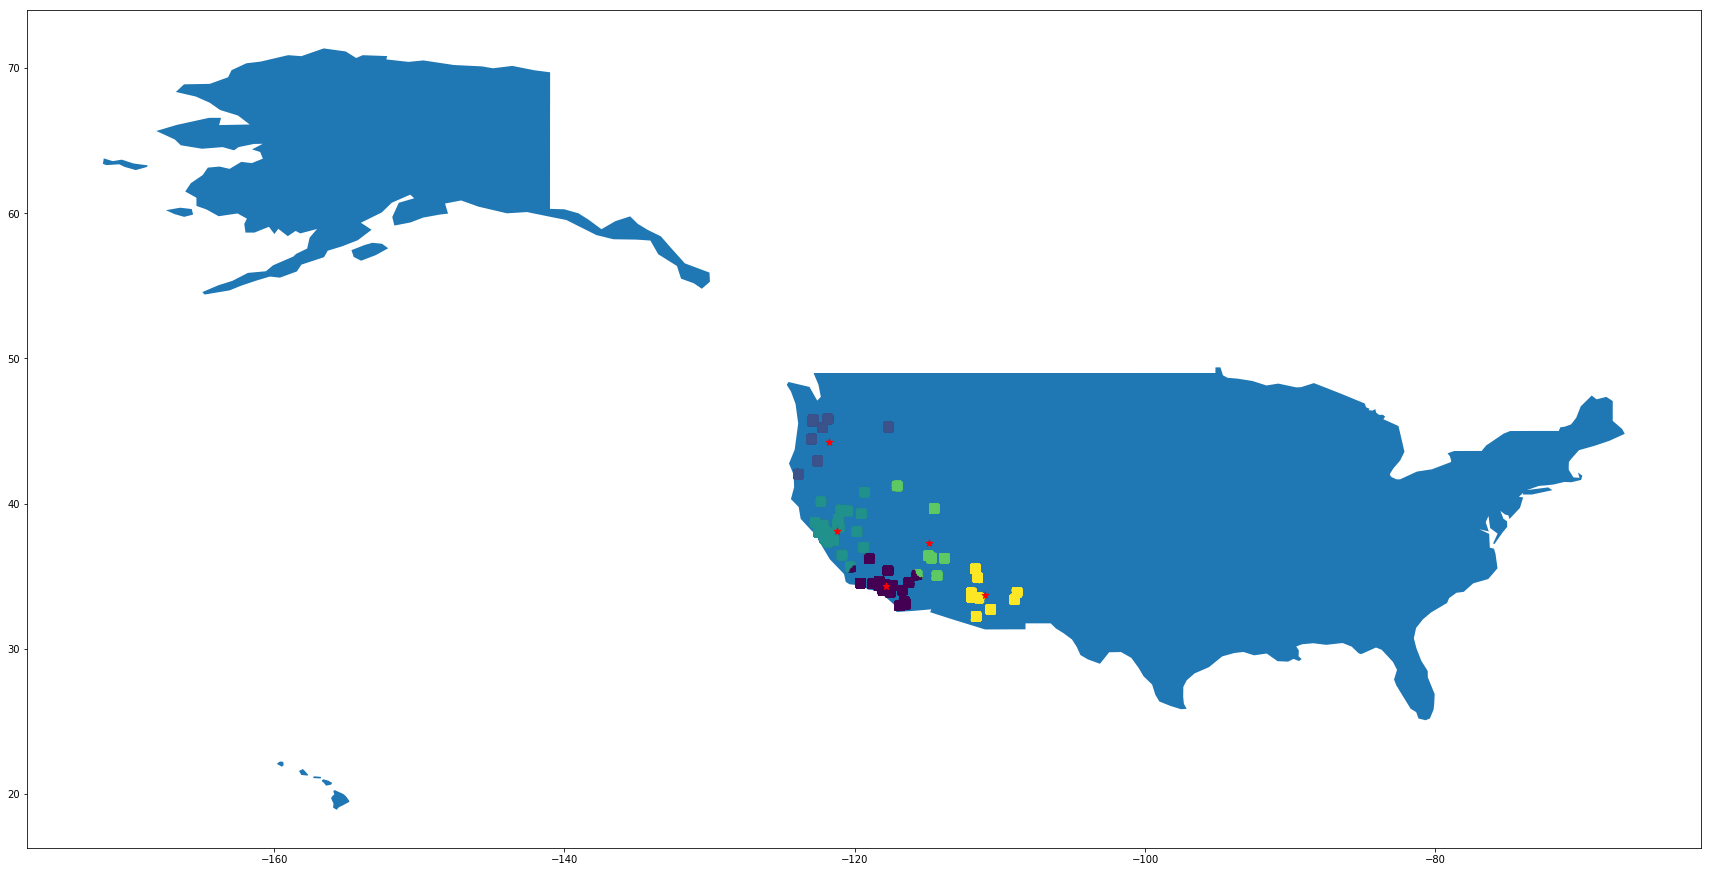

In [15]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show()

Great circle, k=5

Enter distance measure(Euclidean/great circle): "great circle"
Enter number of clusters: 5
Enter input filepath: "s3a://geo-project-data/datafiles/mobilenet/"


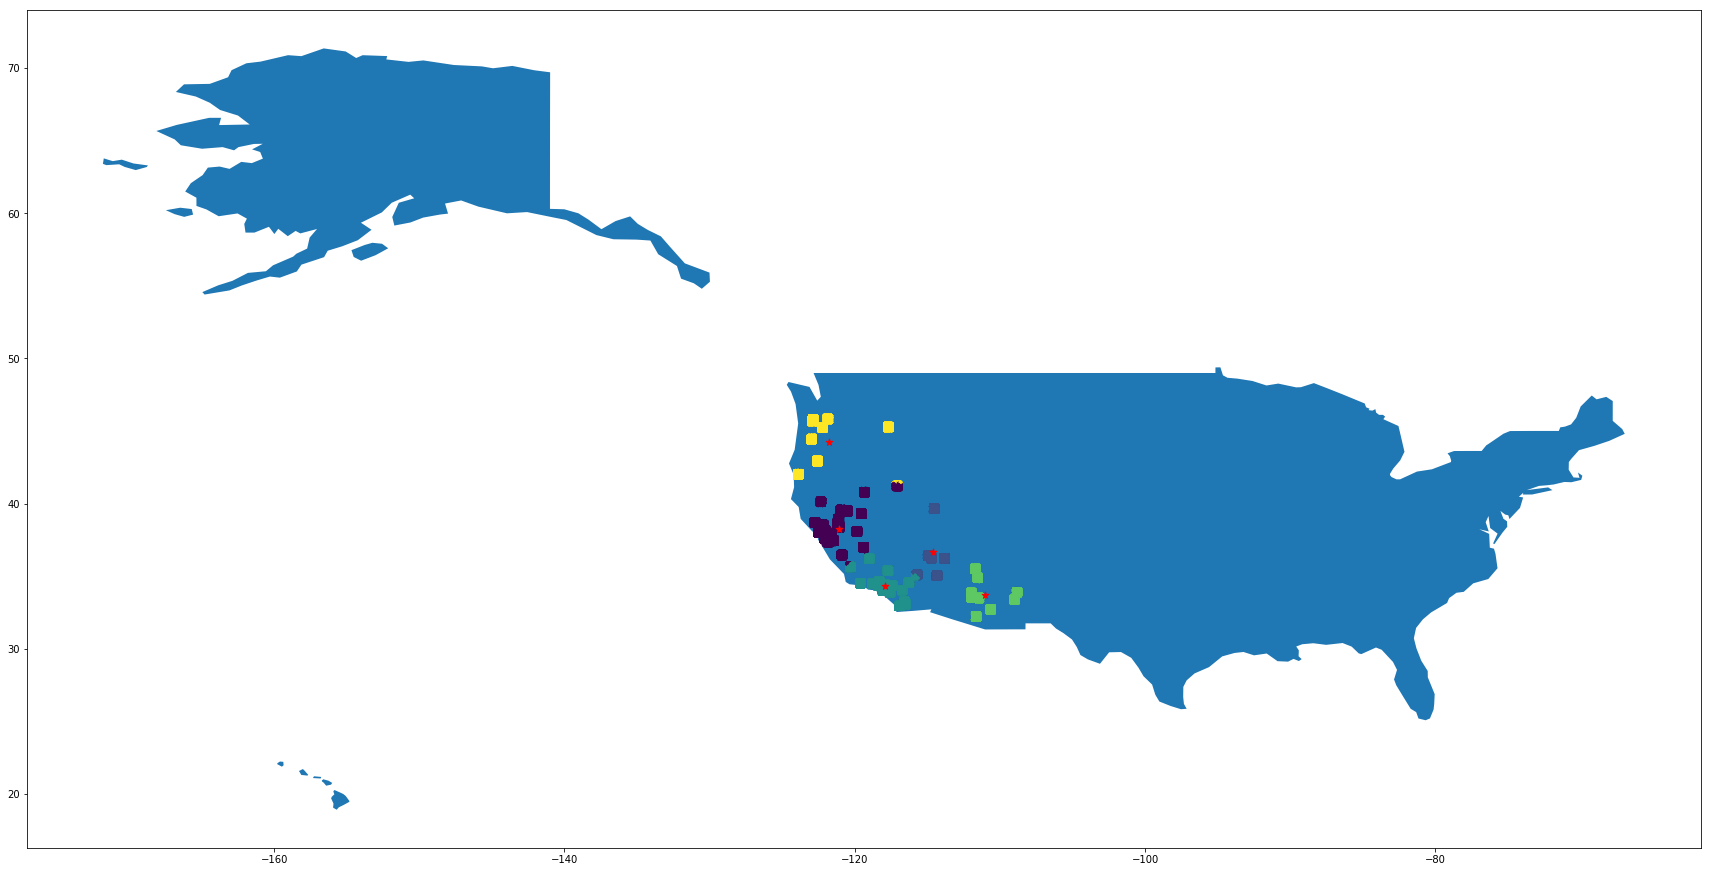

In [17]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show()

# synthetic location data

Euclidean, k=2

Enter distance measure(Euclidean/great circle): "Euclidean"
Enter number of clusters: 2
Enter input filepath: "s3a://geo-project-data/datafiles/synthetic/"


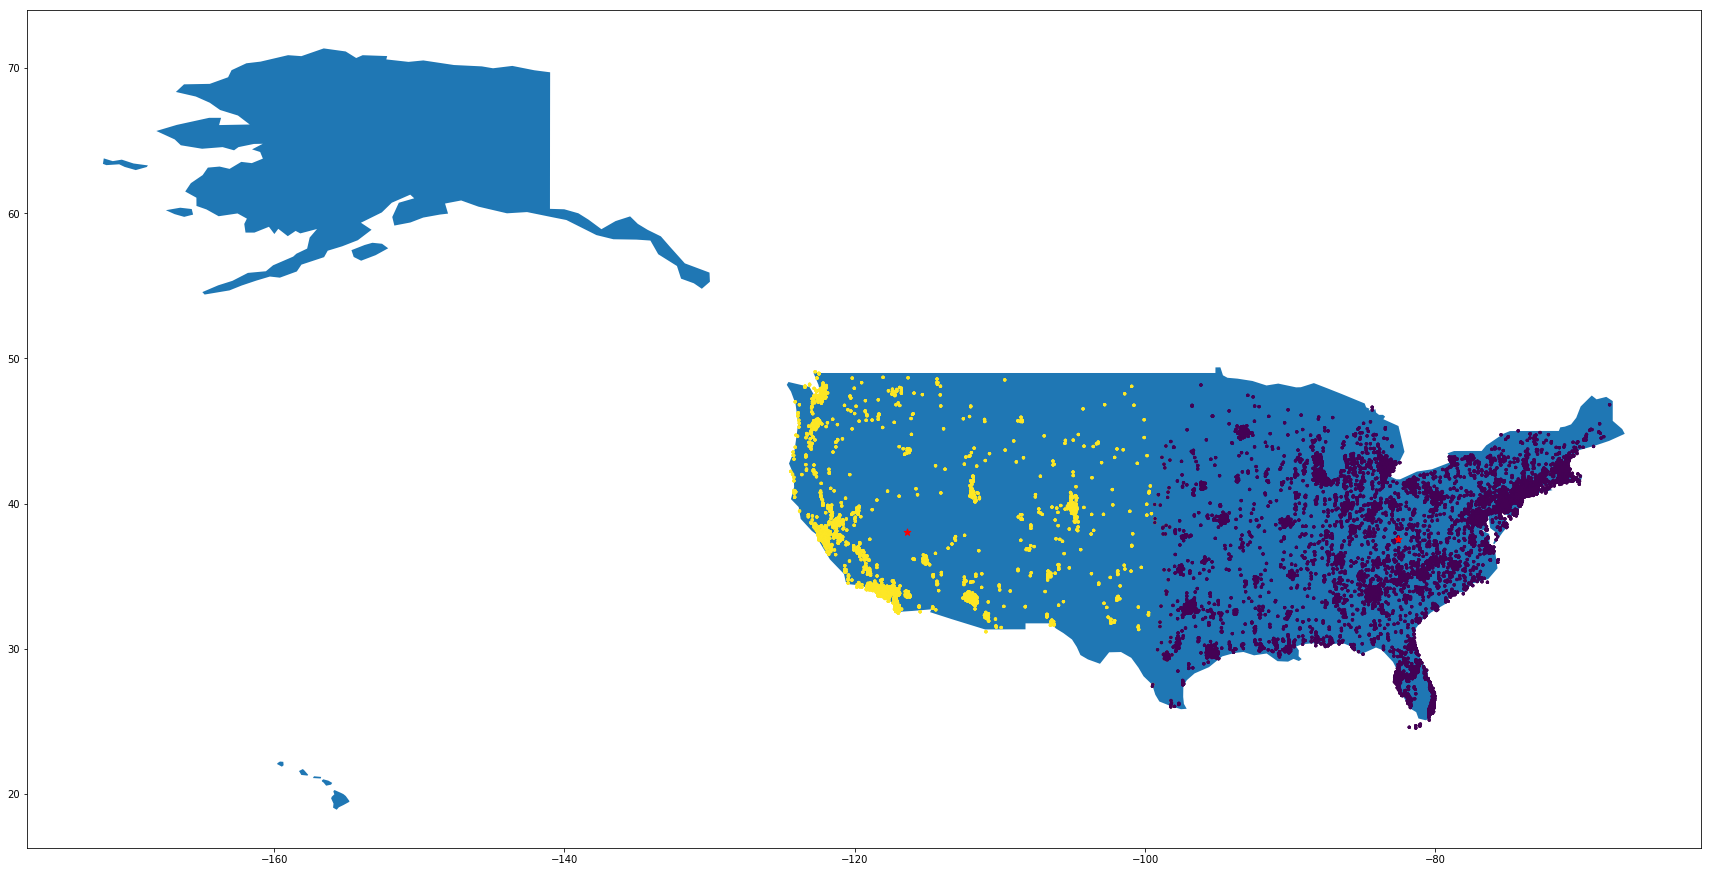

In [19]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show()

Great circle, k=2

Enter distance measure(Euclidean/great circle): "Great circle"
Enter number of clusters: 2
Enter input filepath: "s3a://geo-project-data/datafiles/synthetic/"


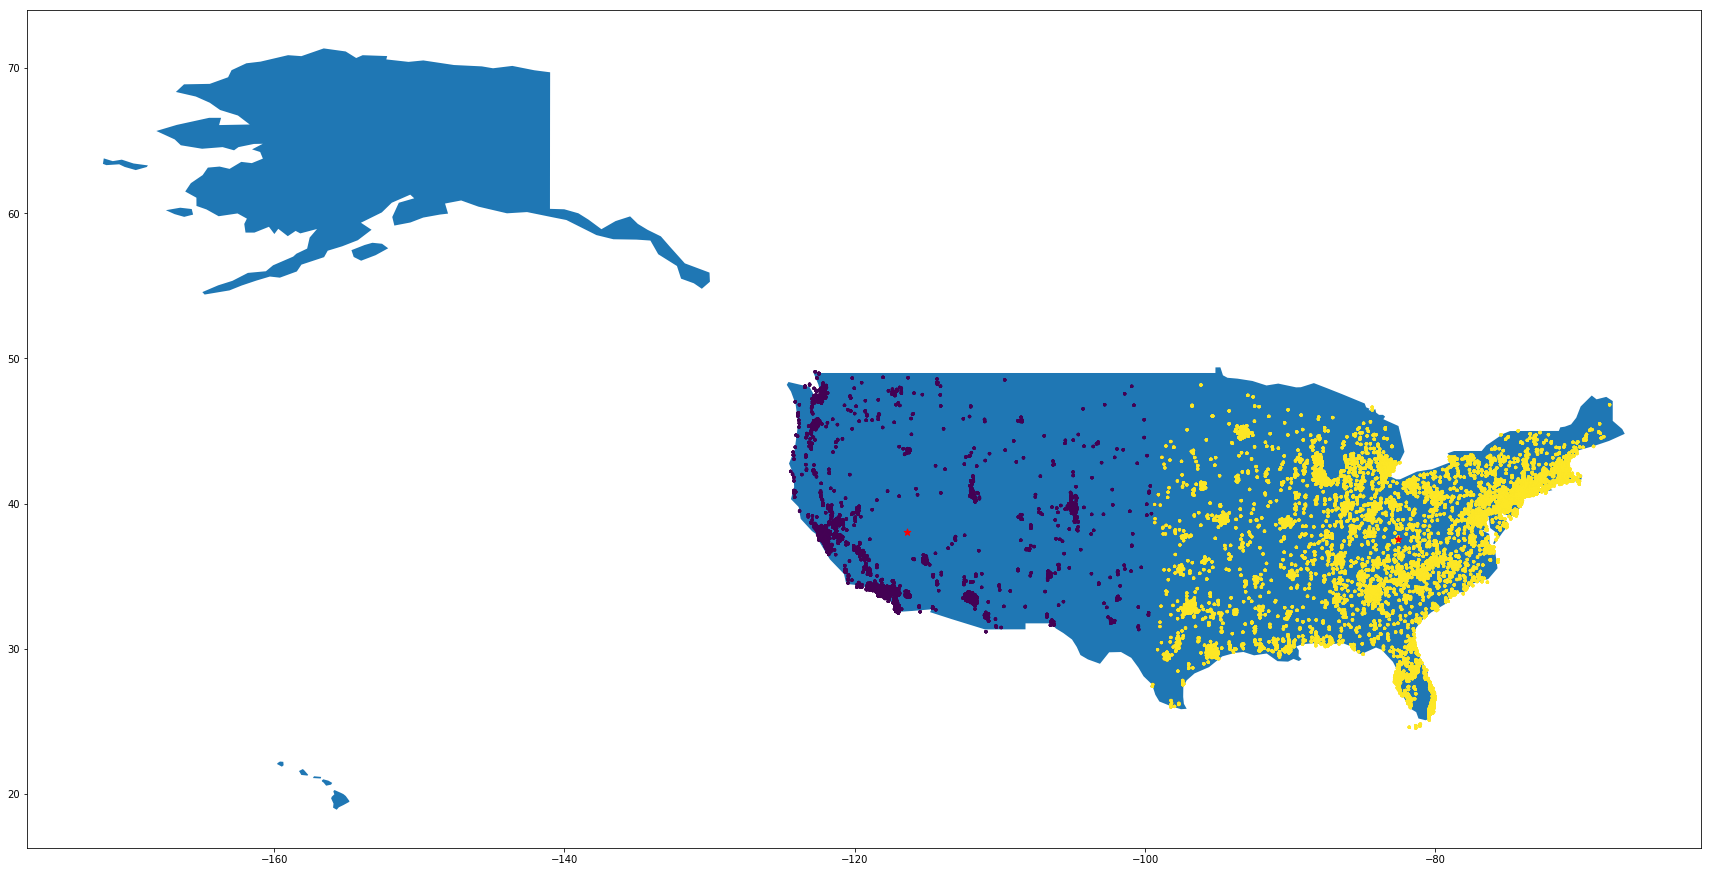

In [20]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show()

Euclidean, k=4

Enter distance measure(Euclidean/great circle): "Euclidean"
Enter number of clusters: 4
Enter input filepath: "s3a://geo-project-data/datafiles/synthetic/"


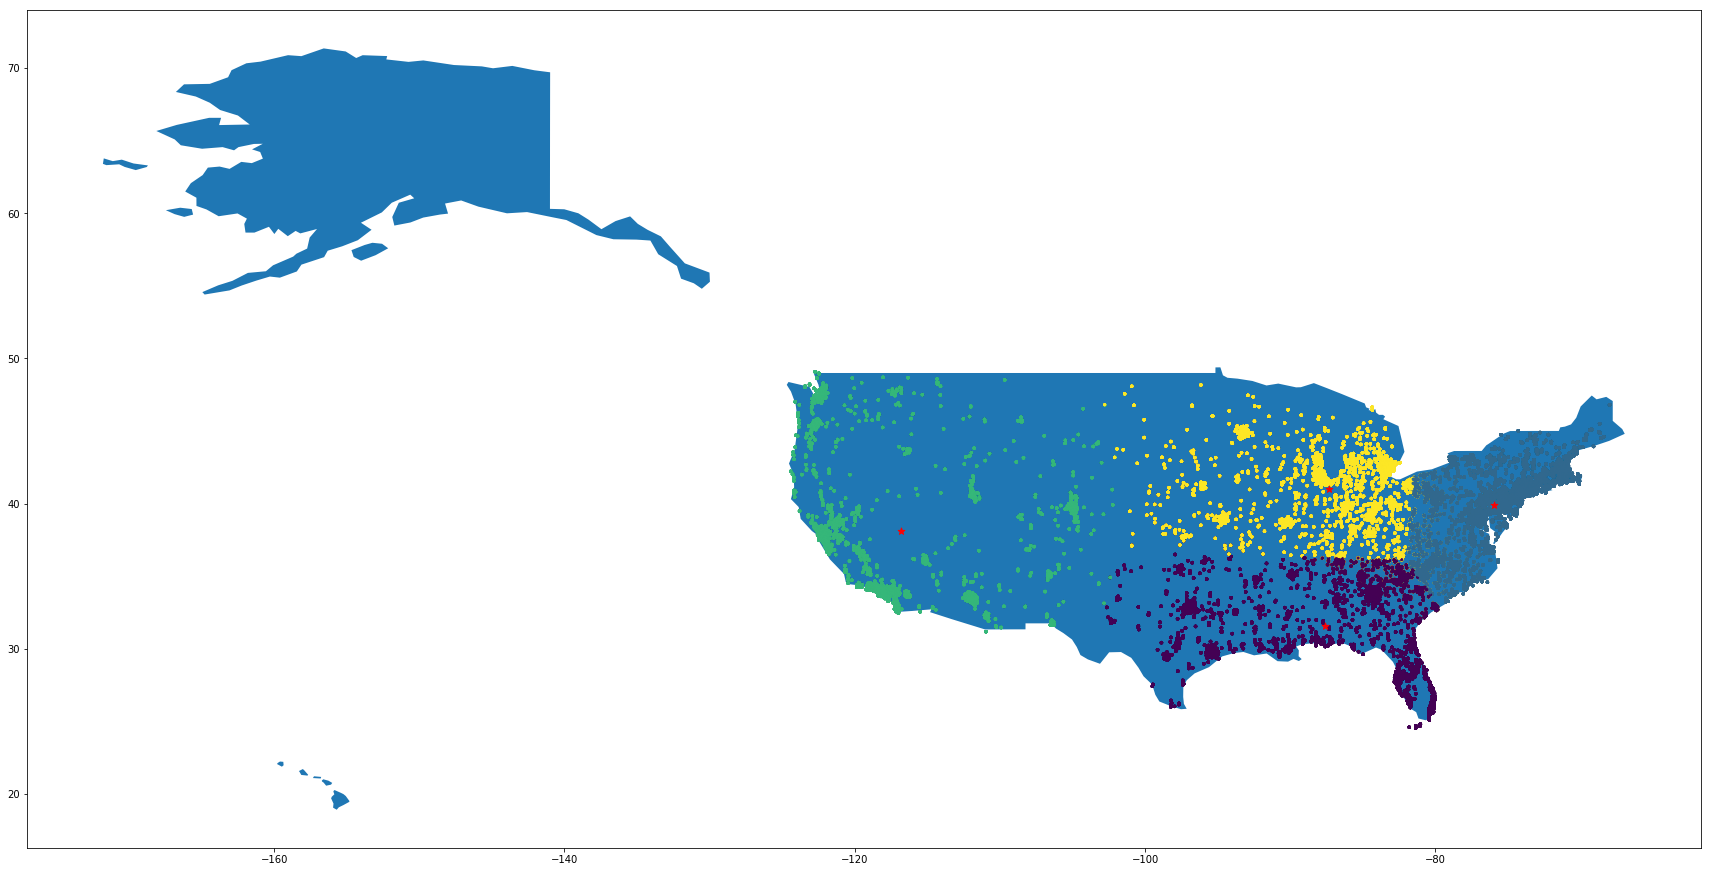

In [21]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show()

Great circle, k=4

Enter distance measure(Euclidean/great circle): "great circle"
Enter number of clusters: 4
Enter input filepath: "s3a://geo-project-data/datafiles/synthetic/"


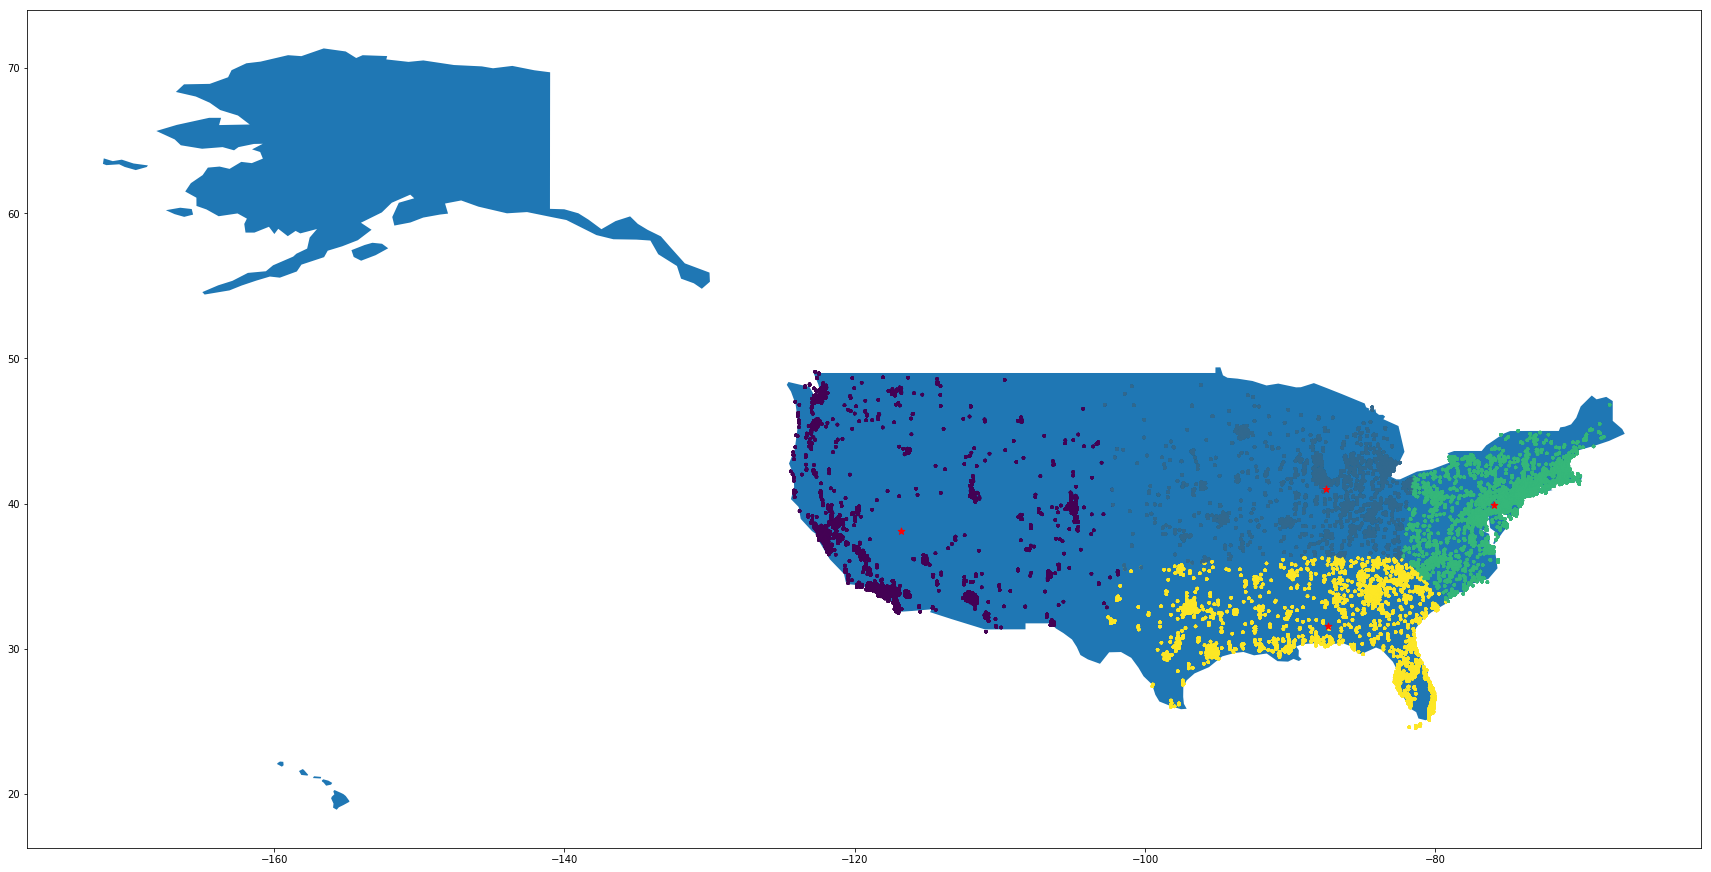

In [22]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show()

# DBpedia USA location data

Euclidean, k=2

Enter distance measure(Euclidean/great circle): "Euclidean"
Enter number of clusters: 2
Enter input filepath: "s3a://geo-project-data/datafiles/dbpedia_USA/"


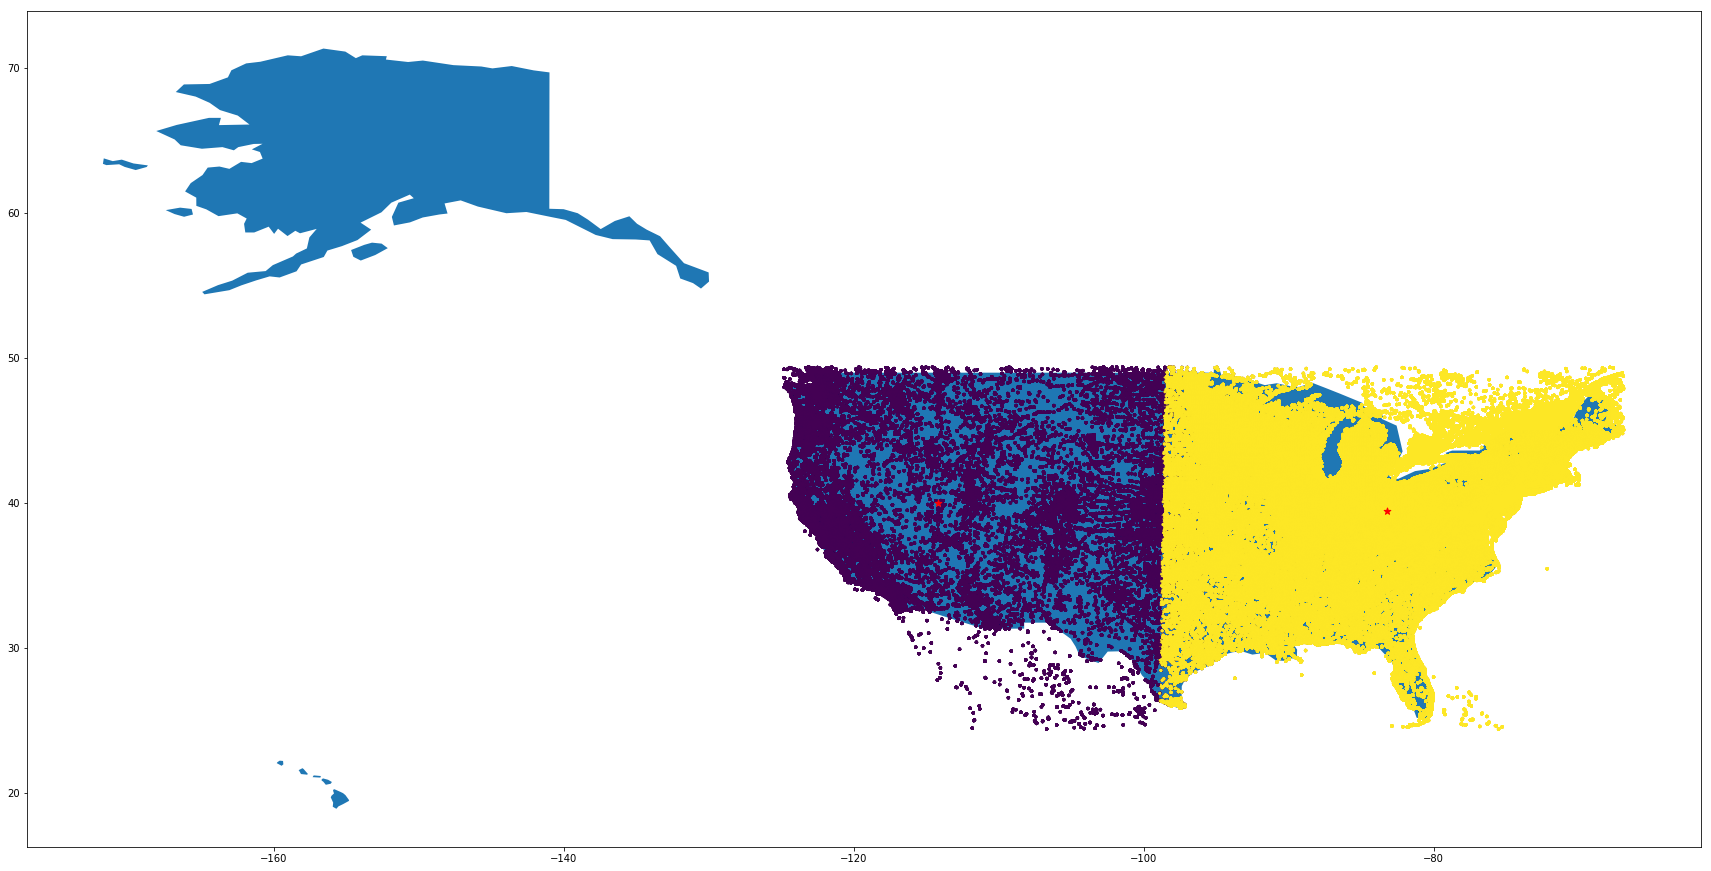

In [23]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show()

Great circle, k=2

Enter distance measure(Euclidean/great circle): "great circle"
Enter number of clusters: 2
Enter input filepath: "s3a://geo-project-data/datafiles/dbpedia_USA/"


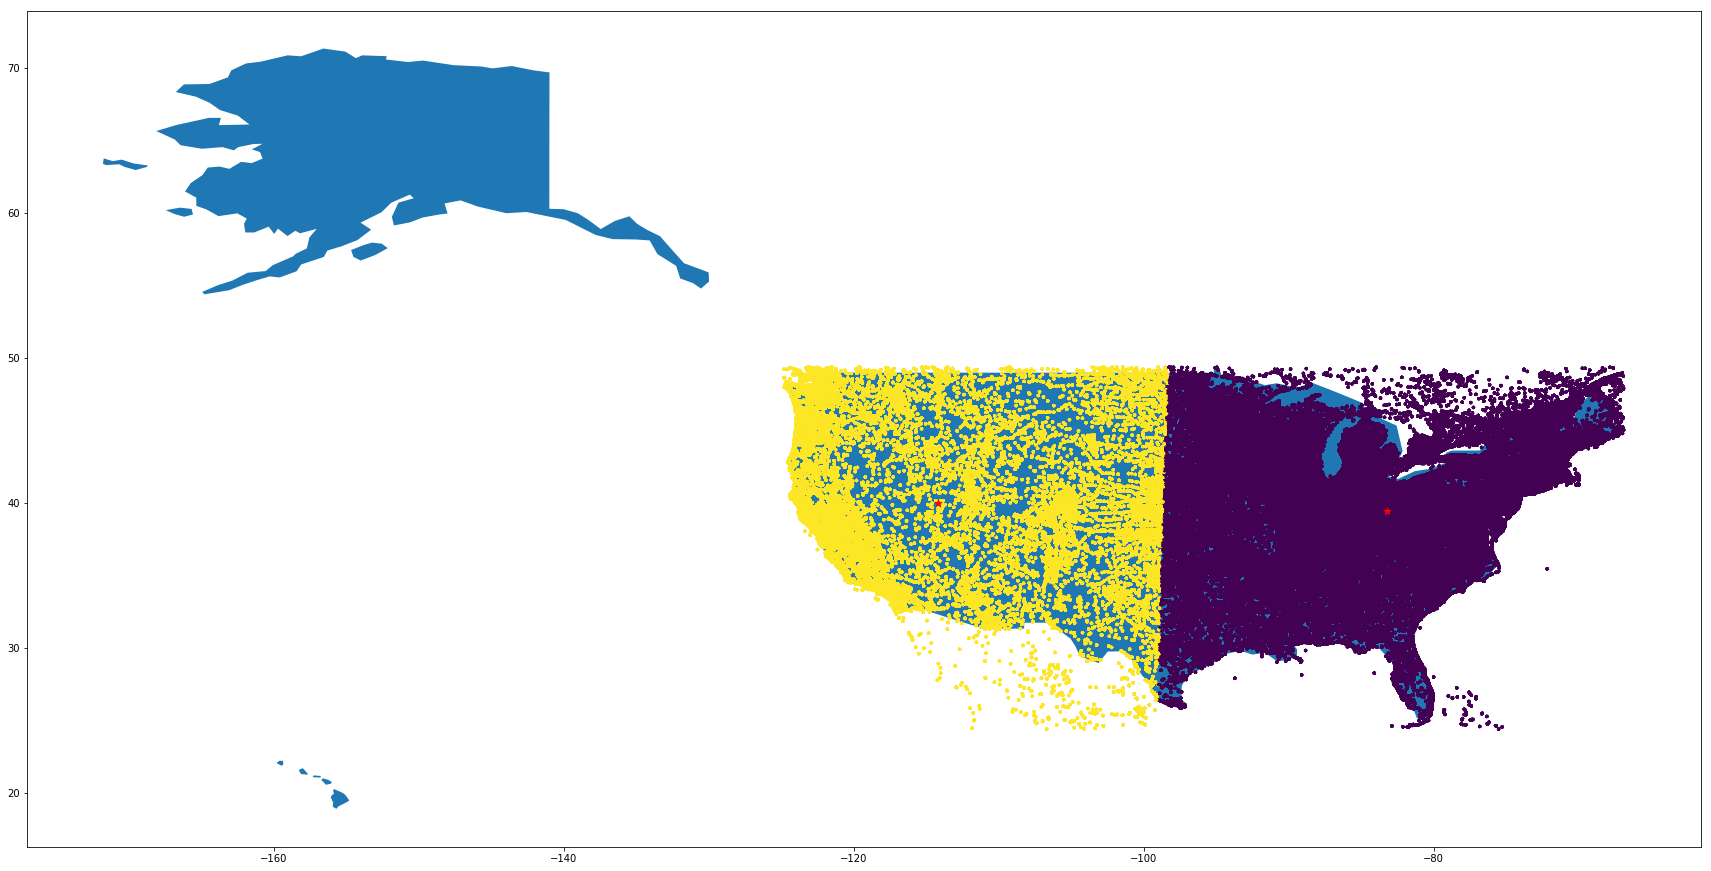

In [24]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show()

Euclidean, k=4

Enter distance measure(Euclidean/great circle): "Euclidean"
Enter number of clusters: 4
Enter input filepath: "s3a://geo-project-data/datafiles/dbpedia_USA/"


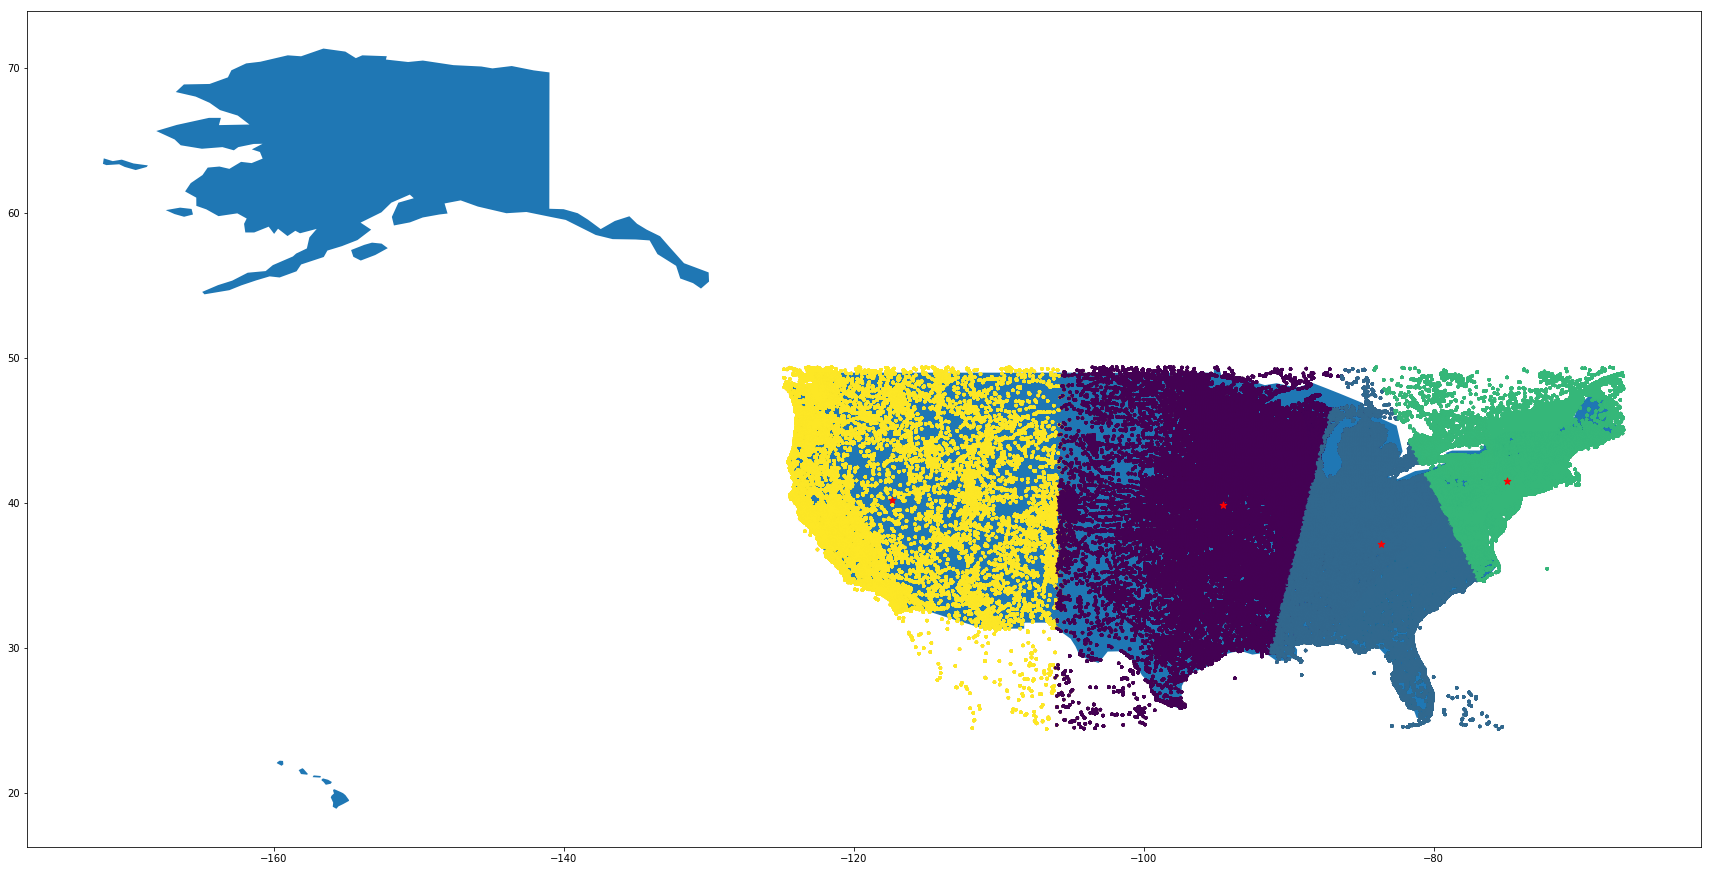

In [25]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show()

Great circle, k=4

Enter distance measure(Euclidean/great circle): "Great circle"
Enter number of clusters: 4
Enter input filepath: "s3a://geo-project-data/datafiles/dbpedia_USA/"


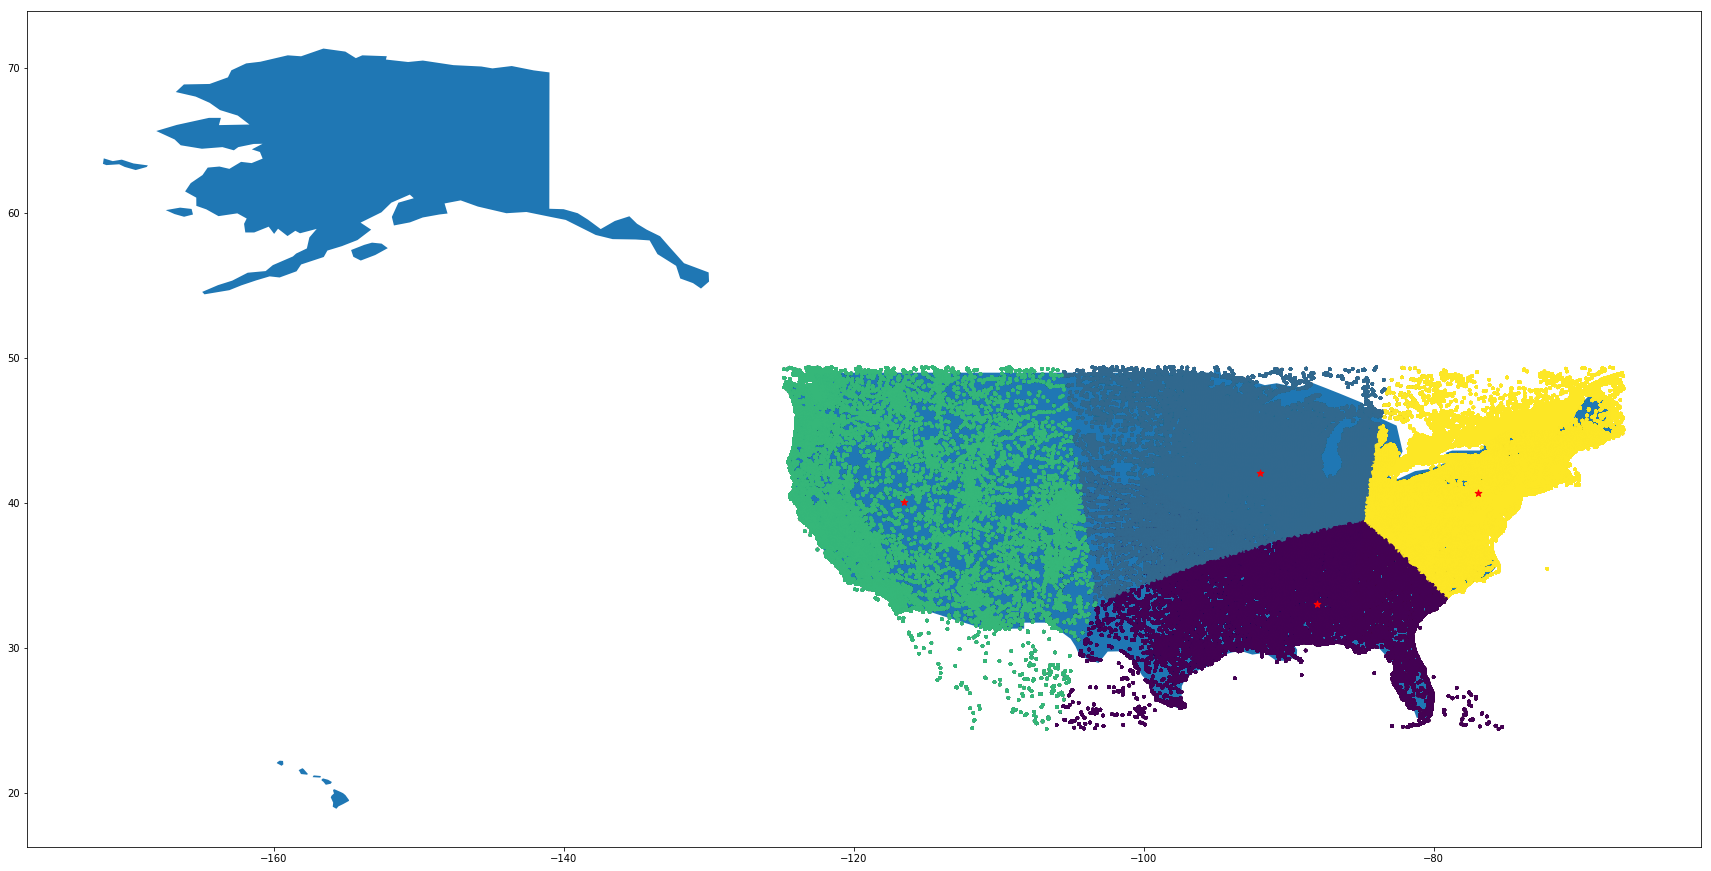

In [26]:
#taking distance measure input from user

distance_measure = input("Enter distance measure(Euclidean/great circle): ").lower()
if (distance_measure != "euclidean") and (distance_measure != "great circle"):
    print("Input must be either Euclidean or great circle")

#taking number of clusters value from users
k = int(input("Enter number of clusters: "))
if k < 1:
    print("value should be an integer greater than 1")

#taking data file path from user
filepath = input("Enter input filepath: ")

#storing (list with all pints mapped to cluster labels) and (list of final centriods) extracted from KMeanAlgorithm function
d,c =KMeanAlgorithm(filepath,k,distance_measure)

#creating pandas dataframes from above lists for visualization..
finalDF = pd.DataFrame(d,columns=["latitude","longitude","cluster"])
centerDF = pd.DataFrame(c,columns=["latitude","longitude"])

#plotting map using geopandas

#create geometry of latitude and longitudes
#create geopandas dataframes, one for USA and other for our data
gdf = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['longitude'], finalDF['latitude']))
cdf = gpd.GeoDataFrame(centerDF, geometry=gpd.points_from_xy(centerDF['longitude'], centerDF['latitude']))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#plotting USA map
ax = world[world.iso_a3 == 'USA'].plot(figsize=(30,30))

gdf['cluster'] = gdf.groupby(['cluster']).ngroup()

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, column='cluster',figsize=(30,30), marker='o', markersize=5)
cdf.plot(ax=ax, color='red', figsize=(30,30), marker='*', markersize=50)

plt.show() 

observation:

1. device dataset has less number of values so the cluster partitions are not too specific
2. For synthetic and dbpedia datasets the cluster regions are more clearly distinguished.
3. With the increase in K value the deviation of points from center is reduced.
4. Euclidean and great circle displayed different cluster partition patterns

# Runtime Analysis

In [9]:
#create a new list to append all the execution times
runtime = []
runtime2 = []
avgtime = []
#inputs
x = [["s3a://geo-project-data/datafiles/mobilenet/",5,"euclidean","Device"],
     ["s3a://geo-project-data/datafiles/mobilenet/",5,"great circle","Device"],
     ["s3a://geo-project-data/datafiles/synthetic/",2,"euclidean","Synthetic"],
     ["s3a://geo-project-data/datafiles/synthetic/",2,"great circle","Synthetic"],
     ["s3a://geo-project-data/datafiles/synthetic/",4,"euclidean","Synthetic"],
     ["s3a://geo-project-data/datafiles/synthetic/",4,"great circle","Synthetic"],
     ["s3a://geo-project-data/datafiles/dbpedia_USA/",2,"euclidean","DBPedia"],
     ["s3a://geo-project-data/datafiles/dbpedia_USA/",2,"great circle","DBPedia"],
     ["s3a://geo-project-data/datafiles/dbpedia_USA/",4,"euclidean","DBPedia"],
     ["s3a://geo-project-data/datafiles/dbpedia_USA/",4,"great circle","DBPedia"]]
     


1st RUN

In [14]:
#loop to find executaion times for all inputs, with cache
for i in x:
    start_time = datetime.now()
    KMeanAlgorithm(i[0],i[1],i[2])
    end_time = datetime.now()
    time = end_time - start_time
    print('Duration: {}'.format(time))
    runtime.append([i[3],i[1],'Y',i[2],time])

Duration: 0:00:31.416589
Duration: 0:00:58.477266
Duration: 0:00:01.876999
Duration: 0:00:02.255648
Duration: 0:00:06.317864
Duration: 0:00:04.514388
Duration: 0:00:35.029559
Duration: 0:00:49.685142
Duration: 0:01:21.595695
Duration: 0:02:38.287585


In [15]:
#loop to find executaion times for all inputs, without cache
for i in x:
    start_time = datetime.now()
    KMeanAlgorithm(i[0],i[1],i[2])
    end_time = datetime.now()
    time = end_time - start_time
    print('Duration: {}'.format(time))
    runtime.append([i[3],i[1],'N',i[2],time])

Duration: 0:00:16.645306
Duration: 0:00:47.380484
Duration: 0:00:02.010163
Duration: 0:00:01.476381
Duration: 0:00:05.864653
Duration: 0:00:06.866152
Duration: 0:00:30.268860
Duration: 0:00:52.298998
Duration: 0:00:32.417253
Duration: 0:02:45.102679


2nd RUN

In [10]:
#loop to find executaion times for all inputs, with cache
for i in x:
    start_time = datetime.now()
    KMeanAlgorithm(i[0],i[1],i[2])
    end_time = datetime.now()
    time = end_time - start_time
    print('Duration: {}'.format(time))
    runtime2.append(time)

Duration: 0:00:16.134803
Duration: 0:00:19.099695
Duration: 0:00:02.260561
Duration: 0:00:01.255958
Duration: 0:00:04.671790
Duration: 0:00:05.080228
Duration: 0:00:33.150899
Duration: 0:00:35.232399
Duration: 0:00:43.196841
Duration: 0:02:01.051618


In [11]:
#loop to find executaion times for all inputs, without cache
for i in x:
    start_time = datetime.now()
    KMeanAlgorithm(i[0],i[1],i[2])
    end_time = datetime.now()
    time = end_time - start_time
    print('Duration: {}'.format(time))
    runtime2.append(time)

Duration: 0:00:20.116122
Duration: 0:01:08.323477
Duration: 0:00:02.148173
Duration: 0:00:02.476700
Duration: 0:00:03.173622
Duration: 0:00:05.114449
Duration: 0:00:18.029080
Duration: 0:00:54.982206
Duration: 0:00:41.505202
Duration: 0:01:08.874380


average run time

In [16]:
#finding average run time for couple of runs and appending the avg time to list
for i in range(20):
    avgtime.append((runtime[i][4]+runtime2[i])/2)

In [17]:
#creating a data frame
timedf = pd.DataFrame(runtime,columns=["data","k","persistant","method","time1"])
timedf["time2"] = runtime2
timedf["Avg_time"] = avgtime

In [18]:
timedf.head(20)

,data,k,persistant,method,time1,time2,Avg_time
0,Device,5,Y,euclidean,00:00:31.416589,00:00:16.134803,00:00:23.775696
1,Device,5,Y,great circle,00:00:58.477266,00:00:19.099695,00:00:38.788480
2,Synthetic,2,Y,euclidean,00:00:01.876999,00:00:02.260561,00:00:02.068780
3,Synthetic,2,Y,great circle,00:00:02.255648,00:00:01.255958,00:00:01.755803
4,Synthetic,4,Y,euclidean,00:00:06.317864,00:00:04.671790,00:00:05.494827
5,Synthetic,4,Y,great circle,00:00:04.514388,00:00:05.080228,00:00:04.797308
6,DBPedia,2,Y,euclidean,00:00:35.029559,00:00:33.150899,00:00:34.090229
7,DBPedia,2,Y,great circle,00:00:49.685142,00:00:35.232399,00:00:42.458770
8,DBPedia,4,Y,euclidean,00:01:21.595695,00:00:43.196841,00:01:02.396268
9,DBPedia,4,Y,great circle,00:02:38.287585,00:02:01.051618,00:02:19.669601


In [22]:
#creating spark dataframe from pandas
Timedf = spark.createDataFrame(timedf)

In [24]:
#storing the spark dataframe to s3 bucket
Timedf.write.csv("s3a://geo-project-data/runtime/", header = True)

Observations:

1. implimenting kmean algorithm with Great circle method takes more time compared to Euclidean distance method
2. Computation time increases with the number of clusters.
3. Time takes for 3 datasets in order: DBPedia > Synthetic > Mobilenet
4. for majority of input condition the run time is reduced due to parsing/cache

Bar chart

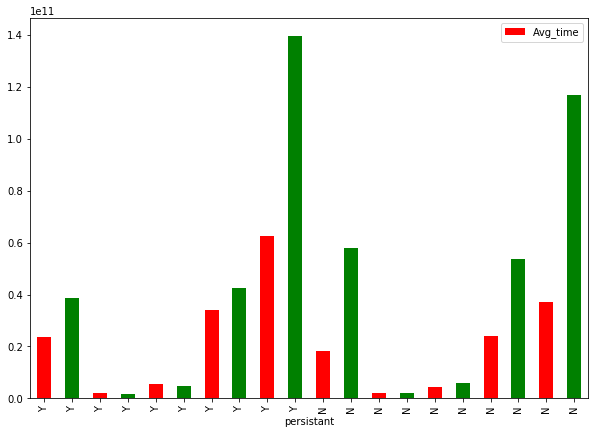

In [38]:
#plotting all rows in dataframe
timedf.plot(x='persistant',y='Avg_time',kind="bar",color=['red', 'green'], figsize=(10,7))

red bars represent euclidean mathod and green bars represent great circle.

implimenting kmean algorithm with Great circle method takes more time compared to Euclidean distance method

In [46]:
timedf[(timedf.method == "euclidean")&(timedf.data =="Synthetic")].head()

,data,k,persistant,method,time1,time2,Avg_time
2,Synthetic,2,Y,euclidean,00:00:01.876999,00:00:02.260561,00:00:02.068780
4,Synthetic,4,Y,euclidean,00:00:06.317864,00:00:04.671790,00:00:05.494827
12,Synthetic,2,N,euclidean,00:00:02.010163,00:00:02.148173,00:00:02.079168
14,Synthetic,4,N,euclidean,00:00:05.864653,00:00:03.173622,00:00:04.519137


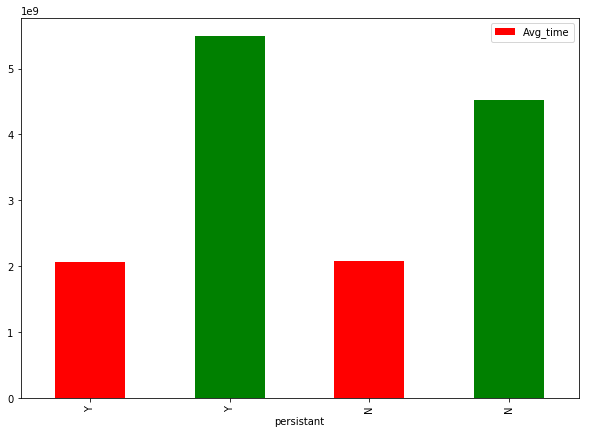

In [45]:
#plotting synthetic data for euclidean method
timedf[(timedf.method == "euclidean")&(timedf.data =="Synthetic")].plot(x='persistant',y='Avg_time',kind="bar",color=['red', 'green'], figsize=(10,7))

red bars represent k=2 and green ones k=4.

Computation time increases with the number of clusters.